# ML Modeling

### The project has three main objectives:

1- Predict total energy consumption (SiteEnergyUse(kBtu)).

2- Predict total CO₂ emissions (TotalGHGEmissions).

3- Evaluate the importance of ENERGYSTARScore in predicting emissions.

## 1.1 Introduction

This notebook aims to model **building energy usage (SiteEnergyUse in kBtu)** using building characteristics, usage types, and engineered features.  
We apply multiple models, tune them, and evaluate performance using R², RMSE, MAE, and MAPE — with a special focus on improving **percentage error** (MAPE).


- Feature engineering
- Hyperparameter tuning
- Comparison of models


# 1.2. Data Loading & Overview


In [24]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_row', 100)

# style de titres
font = {
    'family': 'Arial',
    'color': 'darkred',
    'weight': 'bold',
    'size': 20,
}

In [26]:
# from google.colab import files
# uploaded = files.upload()


In [27]:
building_data = pd.read_csv('building_data_modelling.csv')
building_data.head()

,OSEBuildingID,BuildingType,PropertyName,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,SteamRatio,ElectricityRatio,NaturalGasRatio,SurfacePerBuilding,SurfacePerFloor,ParkingRatio,BuildingRatio,building_age
0,10,NonResidential,Camlin,Downtown,1.0,11,83008,0,83008,Hotel,27.0,5758795.00,176.14,0.0,0.488160,0.511840,83008.0,7546.181818,0.000000,1.000000,99
1,29,NonResidential,WATERTOWN HOTEL,Northeast,1.0,6,88592,30586,58006,Hotel,84.0,3663534.50,90.01,0.0,0.618591,0.381408,58006.0,9667.666667,0.345246,0.654754,24
2,35,NonResidential,Hotel Five,Downtown,1.0,5,68410,16200,52210,Hotel,57.0,4456714.50,128.44,0.0,0.526475,0.473525,52210.0,10442.000000,0.236807,0.763193,47
3,40,NonResidential,Silver Cloud University,Northeast,1.0,4,81871,0,81871,Hotel,29.0,6668568.50,215.00,0.0,0.452331,0.547669,81871.0,20467.750000,0.000000,1.000000,31
4,50,SPS-District K-12,Lawton Elementary,Magnolia / Queen Anne,1.0,2,54986,0,54986,K-12 School,97.0,1650279.25,31.47,0.0,0.737808,0.262192,54986.0,27493.000000,0.000000,1.000000,35


In [28]:
building_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 807 entries, 0 to 806
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   OSEBuildingID           807 non-null    int64  
 1   BuildingType            807 non-null    object 
 2   PropertyName            807 non-null    object 
 3   Neighborhood            807 non-null    object 
 4   NumberofBuildings       807 non-null    float64
 5   NumberofFloors          807 non-null    int64  
 6   PropertyGFATotal        807 non-null    int64  
 7   PropertyGFAParking      807 non-null    int64  
 8   PropertyGFABuilding(s)  807 non-null    int64  
 9   LargestPropertyUseType  807 non-null    object 
 10  ENERGYSTARScore         807 non-null    float64
 11  SiteEnergyUse(kBtu)     807 non-null    float64
 12  TotalGHGEmissions       807 non-null    float64
 13  SteamRatio              807 non-null    float64
 14  ElectricityRatio        807 non-null    fl

In [29]:
building_data.columns

Index(['OSEBuildingID', 'BuildingType', 'PropertyName', 'Neighborhood',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseType', 'ENERGYSTARScore', 'SiteEnergyUse(kBtu)',
       'TotalGHGEmissions', 'SteamRatio', 'ElectricityRatio',
       'NaturalGasRatio', 'SurfacePerBuilding', 'SurfacePerFloor',
       'ParkingRatio', 'BuildingRatio', 'building_age'],
      dtype='object')

 **- These enigeered features will be used after feature importance step.**
 
 - ['SurfacePerBuilding', 'SurfacePerFloor', 'ParkingRatio', 'BuildingRatio']

## A.  without feature engineering 
### 1.3. Data Preprocessing 



In [30]:
# Train-Test Split (Baseline version)

from sklearn.model_selection import train_test_split

# Define engineered features to exclude for baseline
engineered_cols = ['SurfacePerBuilding', 'SurfacePerFloor', 'ParkingRatio', 'BuildingRatio']

# X = all features EXCEPT target and engineered
X_baseline = building_data.drop(columns=['SiteEnergyUse(kBtu)', 'OSEBuildingID', 'PropertyName', 'TotalGHGEmissions'] + engineered_cols)
y = building_data['SiteEnergyUse(kBtu)']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_baseline, y, test_size=0.2, random_state=42
)

# Display shapes
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (645, 13), Test shape: (162, 13)


We split the dataset into training and testing sets using 80/20 ratio.

We exclude engineered features for this baseline model to evaluate how well standard building data performs by itself.



     y = Xw + b

where:
     - `X` = matrix of input features

     - `w` = weights (coefficients)
     
     - `b` = bias (intercept)

     - `y` = predicted output (single column)


   
---

### **🚀 Key Takeaway**
- **`X_baseline` (uppercase)**: Represents **input features (independent variables)** → a **matrix**.
- **`y` (lowercase)**: Represents **the target variable (dependent variable)** → a **vector**.


In [31]:
X_baseline

,BuildingType,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,ENERGYSTARScore,SteamRatio,ElectricityRatio,NaturalGasRatio,building_age
0,NonResidential,Downtown,1.0,11,83008,0,83008,Hotel,27.0,0.0,0.488160,0.511840,99
1,NonResidential,Northeast,1.0,6,88592,30586,58006,Hotel,84.0,0.0,0.618591,0.381408,24
2,NonResidential,Downtown,1.0,5,68410,16200,52210,Hotel,57.0,0.0,0.526475,0.473525,47
3,NonResidential,Northeast,1.0,4,81871,0,81871,Hotel,29.0,0.0,0.452331,0.547669,31
4,SPS-District K-12,Magnolia / Queen Anne,1.0,2,54986,0,54986,K-12 School,97.0,0.0,0.737808,0.262192,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...
802,NonResidential,Lake Union,1.0,12,483397,166208,317189,Office,98.0,0.0,0.838154,0.161846,10
803,NonResidential,Lake Union,1.0,4,126823,41539,85284,Hotel,72.0,0.0,0.681123,0.318876,11
804,NonResidential,Greater Duwamish,1.0,1,52085,4222,47863,Warehouse,37.0,0.0,0.203226,0.796774,70
805,NonResidential,Greater Duwamish,1.0,2,24990,0,24990,Office,9.0,0.0,0.490206,0.509794,96


In [32]:
y

0       5758795.00
1       3663534.50
2       4456714.50
3       6668568.50
4       1650279.25
          ...     
802    13998638.00
803     6042399.50
804     3605855.50
805     4420650.50
806     1325972.75
Name: SiteEnergyUse(kBtu), Length: 807, dtype: float64

# 2.1  Evaluation Setup 

In [33]:
import time
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Global scores dataframe
df_scores = pd.DataFrame(columns=['Model', 'R²', 'RMSE', 'MAE', 'MAPE', 'Time'])

def score(model_name, y_true, y_pred, start_time):
    global df_scores
    
    new_row = pd.DataFrame({
        "Model": [model_name],
        "R²": [r2_score(y_true, y_pred)],
        "RMSE": [np.sqrt(mean_squared_error(y_true, y_pred))],
        "MAE": [mean_absolute_error(y_true, y_pred)],
        "MAPE": [mean_absolute_percentage_error(y_true, y_pred) * 100],
        "Time": [round(time.time() - start_time, 3)]
    })

    df_scores = pd.concat([df_scores, new_row], ignore_index=True)
    return df_scores

# 2 : Baseline Model Training

## 2.1  Preprocessing Pipeline

In [34]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
import time

# Identify columns again
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocessor = make_column_transformer(
    (StandardScaler(), numeric_cols),
    (OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
)

# # Define models
models = {
    "Linear Regression ": LinearRegression(),
    "Ridge Regression ": Ridge(),
    "Decision Tree ": DecisionTreeRegressor(random_state=42),
    "Random Forest ": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting ": GradientBoostingRegressor(n_estimators=300, learning_rate=0.1, max_depth=5, random_state=42)
}

# Train and evaluate each model
for name, model in models.items():
    pipeline = make_pipeline(preprocessor, model)
    start_time = time.time()
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    df_scores = score(name, y_test, y_pred, start_time)

#  Display results
df_scores

/var/folders/dw/ykrtclk13yx5ypn_4csmx6lm0000gn/T/ipykernel_46741/130600368.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_scores = pd.concat([df_scores, new_row], ignore_index=True)


,Model,R²,RMSE,MAE,MAPE,Time
0,Linear Regression,0.807404,1.643558e+06,1.081723e+06,45.945147,0.031
1,Ridge Regression,0.808445,1.639107e+06,1.083882e+06,45.926699,0.041
2,Decision Tree,0.676309,2.130720e+06,1.267735e+06,46.766331,0.042
3,Random Forest,0.845178,1.473593e+06,9.001101e+05,36.538263,0.641
4,Gradient Boosting,0.837269,1.510764e+06,9.148029e+05,33.389183,1.180


# B - Modeling with Engineered Features 
## 1.  Prepare New Feature Set

In [35]:
# Prepare full feature set (with engineered features)
X_eng = building_data.drop(columns=['SiteEnergyUse(kBtu)', 'OSEBuildingID', 'PropertyName', 'TotalGHGEmissions','BuildingType'])
y = building_data['SiteEnergyUse(kBtu)']

# Train-test split again
X_eng_train, X_eng_test, y_train, y_test = train_test_split(
    X_eng, y, test_size=0.2, random_state=42
)

## 2.  Build New Preprocessing Pipeline

In [36]:

# Identify columns again
categorical_cols = X_eng_train.select_dtypes(include='object').columns.tolist()
numeric_cols = X_eng_train.select_dtypes(include=['int64', 'float64']).columns.tolist()


scaler = StandardScaler()
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor_eng = make_column_transformer(
    (scaler, numeric_cols),
    (encoder, categorical_cols)
)


In [37]:
# Define models
models = {
    "Linear Regression (with Eng. Features) ": LinearRegression(),
    "Ridge Regression (with Eng. Features) ": Ridge(),
    "Decision Tree (with Eng. Features) ": DecisionTreeRegressor(random_state=42),
    "Random Forest (with Eng. Features) ": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting (with Eng. Features) ": GradientBoostingRegressor(n_estimators=300, learning_rate=0.1, max_depth=5, random_state=42)
}

#Train and evaluate each model
for name, model in models.items():
    pipeline = make_pipeline(preprocessor_eng, model)
    start_time = time.time()
    pipeline.fit(X_eng_train, y_train)
    y_pred = pipeline.predict(X_eng_test)
    df_scores = score(name, y_test, y_pred, start_time)

#  Display results
df_scores

,Model,R²,RMSE,MAE,MAPE,Time
0,Linear Regression,0.807404,1.643558e+06,1.081723e+06,45.945147,0.031
1,Ridge Regression,0.808445,1.639107e+06,1.083882e+06,45.926699,0.041
2,Decision Tree,0.676309,2.130720e+06,1.267735e+06,46.766331,0.042
3,Random Forest,0.845178,1.473593e+06,9.001101e+05,36.538263,0.641
4,Gradient Boosting,0.837269,1.510764e+06,9.148029e+05,33.389183,1.180
5,Linear Regression (with Eng. Features),0.808966,1.636880e+06,1.079262e+06,44.880246,0.070
6,Ridge Regression (with Eng. Features),0.807930,1.641312e+06,1.083694e+06,44.890492,0.043
7,Decision Tree (with Eng. Features),0.659778,2.184451e+06,1.306830e+06,45.441879,0.054
8,Random Forest (with Eng. Features),0.836452,1.514553e+06,9.207654e+05,36.086438,0.986
9,Gradient Boosting (with Eng. Features),0.821413,1.582657e+06,9.586539e+05,33.096097,1.442


# C. Log-Transformation of the Target Variable

In [38]:
# Drop non-features and define features + log target
X = building_data.drop(columns=['SiteEnergyUse(kBtu)', 'OSEBuildingID', 'PropertyName', 'TotalGHGEmissions','BuildingType'])
y = building_data['SiteEnergyUse(kBtu)']
y_log = np.log1p(y)  # log(1 + y) to handle zero safely

# Train-test split
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)


# Preprocessing
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

preprocessor = make_column_transformer(
    (StandardScaler(), numeric_cols),
    (OneHotEncoder(handle_unknown='ignore'), categorical_cols)
)

In [39]:
# Define models
models = {
    "Linear Regression (log target)": LinearRegression(),
    "Ridge Regression (log target) ": Ridge(),
    "Decision Tree (log target)": DecisionTreeRegressor(random_state=42),
    "Random Forest (log target)": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting (log target)": GradientBoostingRegressor(n_estimators=300, learning_rate=0.1, max_depth=5, random_state=42)
}

#  Train and evaluate each model
for name, model in models.items():
    pipeline = make_pipeline(preprocessor, model)
    start_time = time.time()
    pipeline.fit(X_train, y_train_log)
    y_pred_log = pipeline.predict(X_test)
    y_pred = np.expm1(y_pred_log)
    y_test_actual = np.expm1(y_test_log)
    df_scores = score(name, y_test_actual, y_pred, start_time)

# Step 6: Display results
df_scores

,Model,R²,RMSE,MAE,MAPE,Time
0,Linear Regression,0.807404,1.643558e+06,1.081723e+06,45.945147,0.031
1,Ridge Regression,0.808445,1.639107e+06,1.083882e+06,45.926699,0.041
2,Decision Tree,0.676309,2.130720e+06,1.267735e+06,46.766331,0.042
3,Random Forest,0.845178,1.473593e+06,9.001101e+05,36.538263,0.641
4,Gradient Boosting,0.837269,1.510764e+06,9.148029e+05,33.389183,1.180
5,Linear Regression (with Eng. Features),0.808966,1.636880e+06,1.079262e+06,44.880246,0.070
6,Ridge Regression (with Eng. Features),0.807930,1.641312e+06,1.083694e+06,44.890492,0.043
7,Decision Tree (with Eng. Features),0.659778,2.184451e+06,1.306830e+06,45.441879,0.054
8,Random Forest (with Eng. Features),0.836452,1.514553e+06,9.207654e+05,36.086438,0.986
9,Gradient Boosting (with Eng. Features),0.821413,1.582657e+06,9.586539e+05,33.096097,1.442


# D. Gradient Boosting Hyperparameter Tuning

In [40]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import time
import numpy as np

# Define pipeline
gb_pipeline = make_pipeline(
    preprocessor,
    GradientBoostingRegressor(random_state=42)
)

# Define hyperparameter grid
gb_param_grid = {
    'gradientboostingregressor__n_estimators': [100, 300],
    'gradientboostingregressor__max_depth': [3, 5],
    'gradientboostingregressor__learning_rate': [0.05, 0.1]
}

# Grid search
gb_grid = GridSearchCV(
    estimator=gb_pipeline,
    param_grid=gb_param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1,
    verbose=0
)

# Train the model
start_time = time.time()
gb_grid.fit(X_train, y_train_log)
y_pred_log = gb_grid.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_test_actual = np.expm1(y_test_log)

# Score the model
df_scores = score("GradientBoosting (Tuned)", y_test_actual, y_pred, start_time)
df_scores


,Model,R²,RMSE,MAE,MAPE,Time
0,Linear Regression,0.807404,1.643558e+06,1.081723e+06,45.945147,0.031
1,Ridge Regression,0.808445,1.639107e+06,1.083882e+06,45.926699,0.041
2,Decision Tree,0.676309,2.130720e+06,1.267735e+06,46.766331,0.042
3,Random Forest,0.845178,1.473593e+06,9.001101e+05,36.538263,0.641
4,Gradient Boosting,0.837269,1.510764e+06,9.148029e+05,33.389183,1.180
5,Linear Regression (with Eng. Features),0.808966,1.636880e+06,1.079262e+06,44.880246,0.070
6,Ridge Regression (with Eng. Features),0.807930,1.641312e+06,1.083694e+06,44.890492,0.043
7,Decision Tree (with Eng. Features),0.659778,2.184451e+06,1.306830e+06,45.441879,0.054
8,Random Forest (with Eng. Features),0.836452,1.514553e+06,9.207654e+05,36.086438,0.986
9,Gradient Boosting (with Eng. Features),0.821413,1.582657e+06,9.586539e+05,33.096097,1.442


# E. Feature Importance Extraction using (.feature_importances_) + Plot

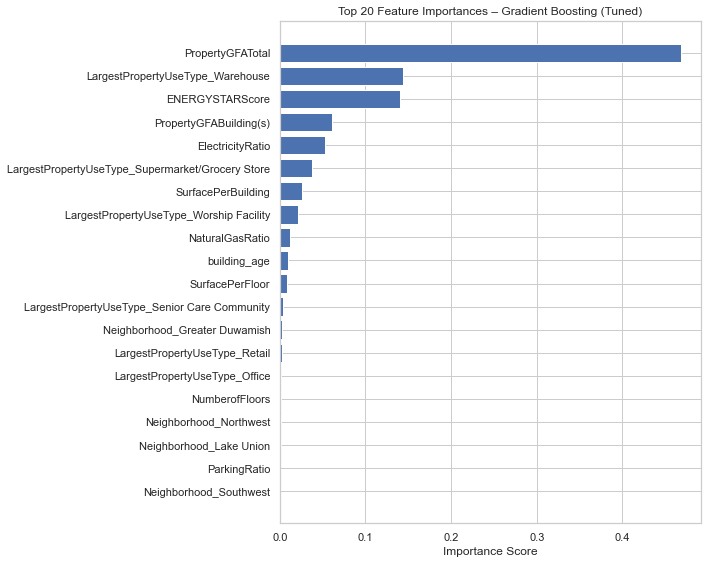

,Feature,Importance
0,PropertyGFATotal,0.468719
1,LargestPropertyUseType_Warehouse,0.144375
2,ENERGYSTARScore,0.140067
3,PropertyGFABuilding(s),0.061041
4,ElectricityRatio,0.052456
5,LargestPropertyUseType_Supermarket/Grocery Store,0.037649
6,SurfacePerBuilding,0.025619
7,LargestPropertyUseType_Worship Facility,0.021599
8,NaturalGasRatio,0.011703
9,building_age,0.009052


In [41]:

# Extract the best model from GridSearchCV
best_gb_model = gb_grid.best_estimator_

#  Get fitted preprocessor from pipeline
fitted_preprocessor = best_gb_model.named_steps['columntransformer']

#  Extract OneHotEncoder feature names
ohe = fitted_preprocessor.named_transformers_['onehotencoder']
ohe_feature_names = ohe.get_feature_names_out(categorical_cols)

#  Combine numeric + encoded categorical features
all_features = numeric_cols + list(ohe_feature_names)

#  Get feature importances from the regressor
importances = best_gb_model.named_steps['gradientboostingregressor'].feature_importances_

#  Create a DataFrame for feature importance
feat_importance = pd.DataFrame({
    'Feature': all_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(10, 8))
plt.barh(feat_importance.head(20)['Feature'][::-1], feat_importance.head(20)['Importance'][::-1])
plt.title('Top 20 Feature Importances – Gradient Boosting (Tuned)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

#  View all sorted features
feat_importance.reset_index(drop=True).head(30)


---

###  Feature Importance Analysis – `SiteEnergyUse(kBtu)` (Gradient Boosting Tuned)

The feature importance results from the **Gradient Boosting Regressor (tuned model)** provide valuable insights into which building characteristics most influence total site energy consumption. The top contributors are as follows:

####  Key Insights:

- **1. `PropertyGFATotal` (46.9%)**  
  This feature, which represents the total floor area of the property, is by far the most dominant predictor of energy consumption. This makes intuitive sense: larger buildings naturally require more energy for heating, cooling, and operation.

- **2. `LargestPropertyUseType_Warehouse` (14.4%)**  
  The fact that warehouse use contributes significantly suggests that energy profiles differ greatly by building function. Warehouses, despite being large, may have different heating/cooling needs compared to offices or hotels.

- **3. `ENERGYSTARScore` (14.0%)**  
  Interestingly, ENERGY STAR Score—a performance metric for energy efficiency—is among the top 3 most important features. This confirms its **strong predictive power** and justifies its relevance in city-wide energy modeling initiatives.

- **4. `PropertyGFABuilding(s)` (6.1%)**  
  This is closely related to `PropertyGFATotal`, but it refers to the floor area dedicated specifically to buildings (excluding parking or other facilities). Its importance highlights the need to isolate usable building space in modeling.

- **5. `ElectricityRatio` (5.2%)**  
  The ratio of energy coming from electricity suggests that buildings with different energy source mixes (e.g., more electricity vs. gas) show distinct consumption behaviors.

#### Other Notable Features:

- **Building structural characteristics** such as `SurfacePerBuilding`, `SurfacePerFloor`, and `NumberofFloors` have smaller but non-negligible impact, indicating that energy use depends not just on size, but also how space is distributed.
- **Age of the building** (`building_age`) and **NaturalGasRatio** are moderately influential.
- **Neighborhood** and **less common property types** (e.g., `Medical Office`, `Hotel`) have very limited impact in this model, likely due to low variability or their energy patterns being captured by higher-level features.

---

###  What This Tells Us:

- Energy consumption is primarily driven by **physical size** and **usage type** of the building.
- **ENERGYSTARScore** is a powerful predictor and should be included in future models, unless we are testing models without it for fairness or comparison (Mission 3).
- There’s a case for **dimensionality reduction**: after the top ~10 features, the importance sharply drops—so feature selection might simplify future models without sacrificing much accuracy.

---



# F. Retrain Model with Top Features

In [42]:
#  Define new feature set
top_features_energy = [
    'PropertyGFATotal',
    'LargestPropertyUseType',    
    'ENERGYSTARScore',
    'PropertyGFABuilding(s)',
    'ElectricityRatio',
    'SurfacePerBuilding'
]

#   Redefine X and y (with log target)
X_top = building_data[top_features_energy]
y = building_data['SiteEnergyUse(kBtu)']
y_log = np.log1p(y)

#   Train-test split
X_train_top, X_test_top, y_train_log_top, y_test_log_top = train_test_split(X_top, y_log, test_size=0.2, random_state=42)

#   Preprocessing
categorical_cols_top = X_train_top.select_dtypes(include='object').columns.tolist()
numeric_cols_top = X_train_top.select_dtypes(include=['int64', 'float64']).columns.tolist()


preprocessor_top = make_column_transformer(
    (StandardScaler(), numeric_cols_top),
    (OneHotEncoder(handle_unknown='ignore'), categorical_cols_top)
)

#   Build pipeline with best params
from sklearn.ensemble import GradientBoostingRegressor


best_params = gb_grid.best_params_  # previously tuned

gb_top_pipeline = make_pipeline(
    preprocessor_top,
    GradientBoostingRegressor(
        n_estimators=best_params['gradientboostingregressor__n_estimators'],
        learning_rate=best_params['gradientboostingregressor__learning_rate'],
        max_depth=best_params['gradientboostingregressor__max_depth'],
        random_state=42
    )
)

#  Fit model
start_time = time.time()
gb_top_pipeline.fit(X_train_top, y_train_log_top)
y_pred_log = gb_top_pipeline.predict(X_test_top)
y_pred = np.expm1(y_pred_log)
y_test_actual = np.expm1(y_test_log_top)

#  Score and compare
df_scores = score("GradientBoosting (Top Features + log + Tuned)", y_test_actual, y_pred, start_time)
df_scores


,Model,R²,RMSE,MAE,MAPE,Time
0,Linear Regression,0.807404,1.643558e+06,1.081723e+06,45.945147,0.031
1,Ridge Regression,0.808445,1.639107e+06,1.083882e+06,45.926699,0.041
2,Decision Tree,0.676309,2.130720e+06,1.267735e+06,46.766331,0.042
3,Random Forest,0.845178,1.473593e+06,9.001101e+05,36.538263,0.641
4,Gradient Boosting,0.837269,1.510764e+06,9.148029e+05,33.389183,1.180
5,Linear Regression (with Eng. Features),0.808966,1.636880e+06,1.079262e+06,44.880246,0.070
6,Ridge Regression (with Eng. Features),0.807930,1.641312e+06,1.083694e+06,44.890492,0.043
7,Decision Tree (with Eng. Features),0.659778,2.184451e+06,1.306830e+06,45.441879,0.054
8,Random Forest (with Eng. Features),0.836452,1.514553e+06,9.207654e+05,36.086438,0.986
9,Gradient Boosting (with Eng. Features),0.821413,1.582657e+06,9.586539e+05,33.096097,1.442




# **Comparative Evaluation of Regression Models Using R², RMSE, MAE, and MAPE**



## Model Performance Comparison: R², RMSE, MAE, and MAPE
This chart visualizes and compares the performance of all tested models across four key regression metrics to assess accuracy and error.




/var/folders/dw/ykrtclk13yx5ypn_4csmx6lm0000gn/T/ipykernel_46741/3200751887.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='R²', y='Model', data=df_scores.sort_values('R²', ascending=False), ax=axes[0, 0], palette="viridis")
/var/folders/dw/ykrtclk13yx5ypn_4csmx6lm0000gn/T/ipykernel_46741/3200751887.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='RMSE', y='Model', data=df_scores.sort_values('RMSE'), ax=axes[0, 1], palette="magma")
/var/folders/dw/ykrtclk13yx5ypn_4csmx6lm0000gn/T/ipykernel_46741/3200751887.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for 

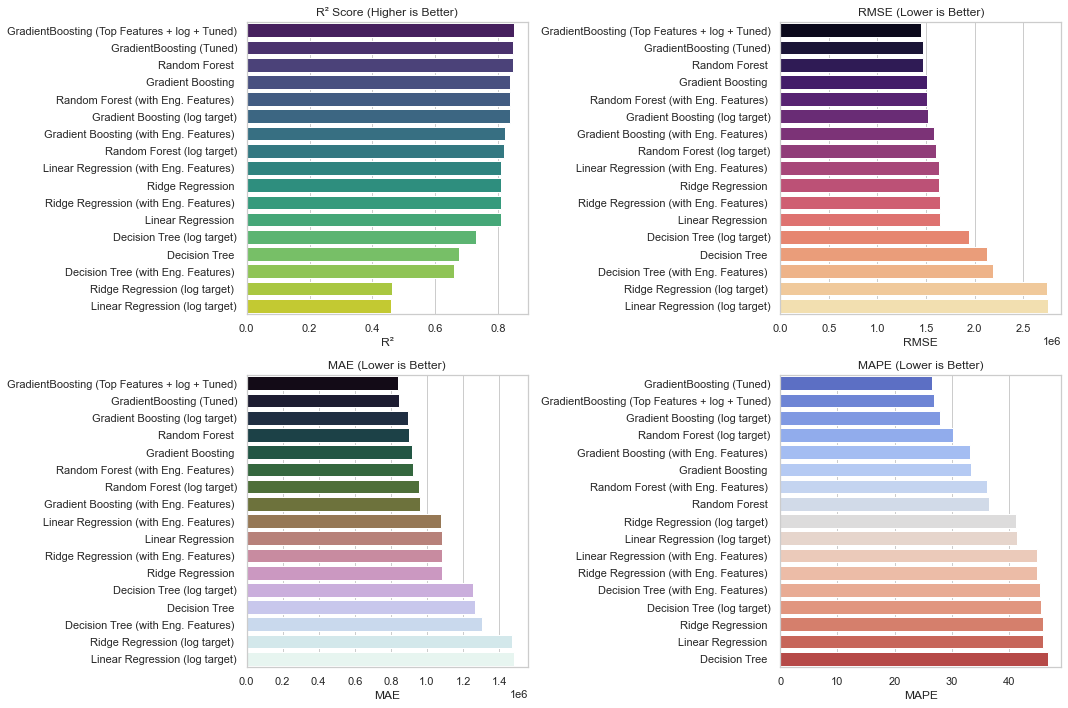

In [43]:
# Set figure style
sns.set(style="whitegrid")

# Create 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# --- Plot R² (higher is better)
sns.barplot(x='R²', y='Model', data=df_scores.sort_values('R²', ascending=False), ax=axes[0, 0], palette="viridis")
axes[0, 0].set_title('R² Score (Higher is Better)')
axes[0, 0].set_xlabel('R²')
axes[0, 0].set_ylabel('')

# --- Plot RMSE (lower is better)
sns.barplot(x='RMSE', y='Model', data=df_scores.sort_values('RMSE'), ax=axes[0, 1], palette="magma")
axes[0, 1].set_title('RMSE (Lower is Better)')
axes[0, 1].set_xlabel('RMSE')
axes[0, 1].set_ylabel('')

# --- Plot MAE (lower is better)
sns.barplot(x='MAE', y='Model', data=df_scores.sort_values('MAE'), ax=axes[1, 0], palette="cubehelix")
axes[1, 0].set_title('MAE (Lower is Better)')
axes[1, 0].set_xlabel('MAE')
axes[1, 0].set_ylabel('')

# --- Plot MAPE (lower is better)
sns.barplot(x='MAPE', y='Model', data=df_scores.sort_values('MAPE'), ax=axes[1, 1], palette="coolwarm")
axes[1, 1].set_title('MAPE (Lower is Better)')
axes[1, 1].set_xlabel('MAPE')
axes[1, 1].set_ylabel('')

# --- Layout and display
plt.tight_layout()
plt.show()


# Save the Final Model Pipeline : GradientBoosting_SiteEnergyUse(kBtu)

In [44]:
import joblib

# Save the entire pipeline (preprocessing + model)
joblib.dump(gb_top_pipeline, "GradientBoosting_SiteEnergyUse(kBtu).joblib")

print(" Model saved successfully as 'GradientBoosting_SiteEnergyUse(kBtu).joblib'")


 Model saved successfully as 'GradientBoosting_SiteEnergyUse(kBtu).joblib'
